In [1]:
# Loading Libraries
import pandas as pd
import sklearn as sk
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import log_hyperu as hyperu
import tgr as tgr
import math
import time
import csv
import re
import os

from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# Prediction Simulation Study
### Output Table

In [1]:
import os
import pandas as pd

# Placeholder for the folder path
folder_path = 'Final Files'

# Initialize an empty list to store the results
results = []

# Iterate through each file in the folder
for file_name in os.listdir(folder_path):
    if file_name.endswith('.xlsx'):
        # Extract scenario parameters from the file name
        scenario = tuple(map(int, file_name.replace('.xlsx', '').split('_')))
        
        # Load the Excel file
        file_path = os.path.join(folder_path, file_name)
        df = pd.read_excel(file_path)
        
        # Compute mean, median, and standard deviation of the loss for each method
        stats = df.groupby('Name')['Loss'].agg(['mean', 'median', 'std']).reset_index()
        
        # Reshape the data to have methods with stats as columns
        stats = stats.set_index('Name').unstack().to_frame().T
        stats.columns = [f"{method} {stat}" for method, stat in stats.columns]
        stats.index = pd.MultiIndex.from_tuples([scenario], names=['Samples', 'Features', 'Non-Zero Features'])
        
        # Append the results
        results.append(stats)

# Concatenate all results into a single DataFrame
final_df = pd.concat(results)

# Save the final DataFrame to a CSV file (optional)
# final_df.to_csv('simulation_summary.csv')

# Return the final DataFrame
final_df.head()


mean Arctan  mean Gaussian  mean LASSO  \
Samples Features Non-Zero Features                                           
100     10       1                     8.863887       8.678954    9.052626   
                 5                    56.565317      57.244630   56.948858   
                 9                   116.152157     116.713369  117.717157   
        25       13                  174.514219     173.974815  174.085742   
                 23                  374.190135     374.706649  375.219191   

                                      mean OLS  mean Ridge  \
Samples Features Non-Zero Features                           
100     10       1                    9.423946    9.394928   
                 5                   57.357848   57.350824   
                 9                  116.117109  116.923673   
        25       13                 174.105427  172.683927   
                 23                 372.536190  372.548317   

                                    mean TGR Setting 1  mean TGR Setting 2  \
Samples Features Non-Zero Features                                           
100     10       1                            9.502601            8.691469   
                 5                           55.014809           57.423201   
                 9                          118.196208          117.065177   
        25       13                         173.319476          175.256952   
                 23                         370.122378          375.738451   

                                    mean TGR Setting 3  median Arctan  \
Samples Features Non-Zero Features                                      
100     10       1                            9.393033       8.606881   
                 5                           56.856301      51.512199   
                 9                          117.578652      98.745590   
        25       13                         174.474398     143.583649   
                 23                         371.922130     371.785065   

                                    median Gaussian  ...  \
Samples Features Non-Zero Features                   ...   
100     10       1                         8.884330  ...   
                 5                        52.863258  ...   
                 9                       103.095352  ...   
        25       13                      144.763550  ...   
                 23                      365.881409  ...   

                                    median TGR Setting 2  \
Samples Features Non-Zero Features                         
100     10       1                              8.413029   
                 5                             52.906006   
                 9                            103.667992   
        25       13                           152.450348   
                 23                           375.655701   

                                    median TGR Setting 3  std Arctan  \
Samples Features Non-Zero Features                                     
100     10       1                              9.017416    3.295913   
                 5                             53.085438   18.628019   
                 9                            102.379524   45.467970   
        25       13                           144.349838   75.149004   
                 23                           371.569061  121.703496   

                                    std Gaussian   std LASSO     std OLS  \
Samples Features Non-Zero Features                                         
100     10       1                      2.887889    3.351276    3.128375   
                 5                     18.709102   18.756765   18.573033   
                 9                     47.096721   46.084785   44.898733   
        25       13                    72.858222   71.812414   74.370886   
                 23                   121.828352  122.728403  119.117936   

                                     std Ridge  std TGR Setting 1  \
Samples Features Non-Zero Features            

In [30]:
# Extract columns related to mean and std
mean_cols = {col.replace('mean', ''): col for col in final_df.columns if 'mean' in col}
std_cols = {col.replace('std', ''): col for col in final_df.columns if 'std' in col}

# Create a new DataFrame to store the merged columns
merged_df = pd.DataFrame(index=final_df.index)

# Merge the mean and std columns
for method in mean_cols.keys():
    if method in std_cols:
        merged_df[method] = round(final_df[mean_cols[method]],3).astype(str) + ' (' + round(final_df[std_cols[method]],3).astype(str) + ')'

# Add back the median columns unchanged
median_cols = [col for col in final_df.columns if 'median' in col]
#merged_df = pd.concat([merged_df, final_df[median_cols]], axis=1)

# Display or save the updated DataFrame
merged_df = merged_df[[' OLS',  ' LASSO',  ' Ridge', ' Arctan', ' Gaussian', ' TGR Setting 1', ' TGR Setting 2', ' TGR Setting 3']]
merged_df = merged_df.sort_values(by=['Samples', 'Features', 'Non-Zero Features'], ascending=[True, True, True])
merged_df.head()
# Optionally save to a CSV file
# merged_df.to_csv('merged_methods_summary.csv', index=False)


OLS              LASSO  \
Samples Features Non-Zero Features                                         
10      10       1                    12.746 (14.993)      7.163 (5.372)   
                 5                     83.12 (59.984)    84.273 (62.912)   
                 9                  220.161 (360.491)  224.464 (365.323)   
        25       3                    50.664 (49.508)    44.771 (34.833)   
                 13                 235.981 (256.182)  234.756 (260.716)   

                                                Ridge             Arctan  \
Samples Features Non-Zero Features                                         
10      10       1                      8.589 (5.595)     9.551 (13.523)   
                 5                    81.288 (53.656)     85.04 (61.694)   
                 9                  221.269 (354.385)   219.74 (356.702)   
        25       3                    44.945 (40.545)    48.249 (40.413)   
                 13                 238.259 (261.011)  235.193 (259.992)   

                                             Gaussian      TGR Setting 1  \
Samples Features Non-Zero Features                                         
10      10       1                      6.751 (6.217)       7.722 (4.92)   
                 5                     84.585 (66.75)    80.645 (51.107)   
                 9                  219.399 (354.232)  228.631 (356.692)   
        25       3                    53.057 (40.557)    37.565 (31.623)   
                 13                 237.285 (267.622)  233.065 (251.616)   

                                        TGR Setting 2      TGR Setting 3  
Samples Features Non-Zero Features                                        
10      10       1                      5.348 (3.151)      6.663 (4.127)  
                 5                     79.03 (50.777)    89.188 (57.828)  
                 9                  219.837 (355.328)   239.05 (335.249)  
        25       3                    37.675 (29.551)    38.136 (32.025)  
                 13                 231.373 (249.771)  261.546 (311.695)

In [31]:
# Extract columns related to mean and median
mean_cols = [col for col in final_df.columns if 'mean' in col]
median_cols = [col for col in final_df.columns if 'median' in col]

# Determine the best method based on mean (smallest mean loss) and remove "mean_" prefix
best_mean_methods = final_df[mean_cols].idxmin(axis=1).str.replace('mean ', '')

# Determine the best method based on median (smallest median loss) and remove "median_" prefix
best_median_methods = final_df[median_cols].idxmin(axis=1).str.replace('median ', '')

# Create a new DataFrame to store the scenario values and the best methods
best_methods_df = final_df.index.to_frame(index=False)  # Get the scenario values from the MultiIndex
best_methods_df['Best_Method_Mean'] = best_mean_methods.values
best_methods_df['Best_Method_Median'] = best_median_methods.values

# Display the new DataFrame
best_methods_df = best_methods_df.sort_values(by=['Samples', 'Features', 'Non-Zero Features'], ascending=[True, True, True])
best_methods_df.head()

latex_table_best_methods = best_methods_df.to_latex(index=False)
with open('latex_best_methods.tex', 'w') as file:
    file.write(latex_table_best_methods)


,Samples,Features,Non-Zero Features,Best_Method_Mean,Best_Method_Median
9,10,10,1,TGR Setting 2,TGR Setting 2
10,10,10,5,TGR Setting 2,TGR Setting 2
11,10,10,9,Gaussian,Arctan
14,10,25,3,TGR Setting 1,Arctan
12,10,25,13,TGR Setting 2,Gaussian


In [32]:
# Get Table to LATEX
#df = pd.read_excel('summary_statistics.xlsx', sheet_name='Final')
latex_table_simulation = merged_df.to_latex(index=True)
with open('latex_table_simulation.tex', 'w') as file:
    file.write(latex_table_simulation)

In [33]:
import re

# Path to the input file
input_file_path = 'latex_table_simulation.tex'

# Path to the output file
output_file_path = 'outputtable_adjusted.txt'

# Read the content of the input file
with open(input_file_path, 'r') as file:
    content = file.read()

# Regular expression pattern to find "mean (std)"
pattern = r"(\d+\.\d+)\s\((\d+\.\d+)\)"
replacement = r"\\makecell{\1 \\\\ (\2)}"

# Perform the replacement
adjusted_content = re.sub(pattern, replacement, content)

# Save the adjusted content back to a new text file
with open(output_file_path, 'w') as file:
    file.write(adjusted_content)

print(f"Adjusted file saved to {output_file_path}")


Adjusted file saved to outputtable_adjusted.txt


### Boxplot of Specific Scenario

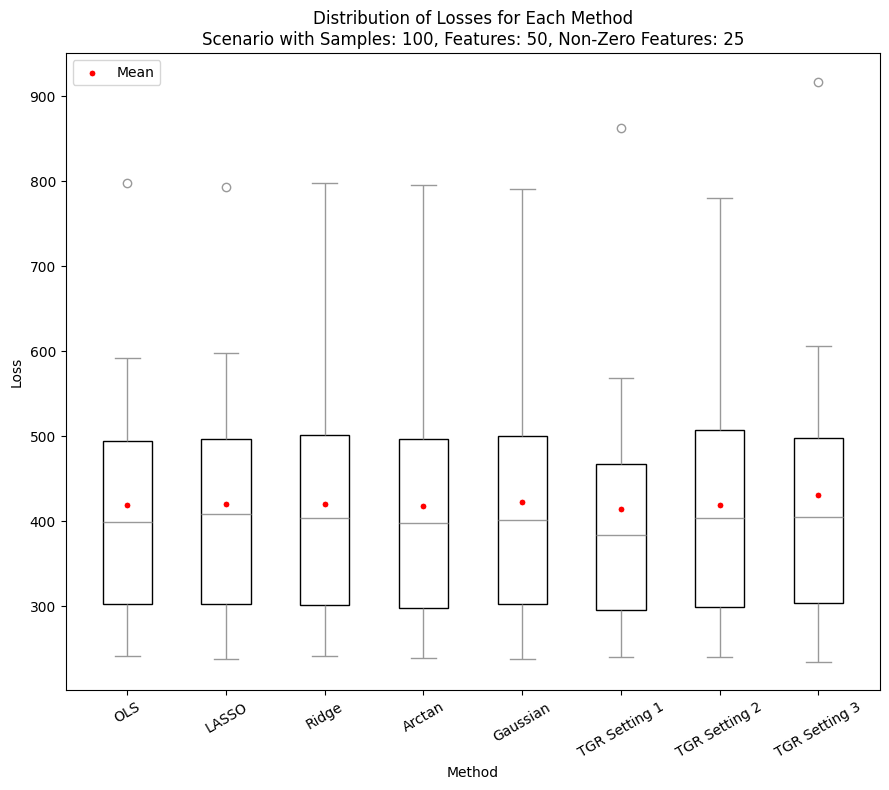

In [46]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_boxplots_for_scenario(samples, features, non_zero_features, original_folder_path):
    # Construct the file name based on the scenario parameters
    file_name = f"{samples}_{features}_{non_zero_features}.xlsx"
    
    # Load the original data
    original_file_path = os.path.join(original_folder_path, file_name)
    original_df = pd.read_excel(original_file_path)
    
    # Plot the boxplots for each method
    plt.figure(figsize=(9, 8))
    sns.boxplot(x='Name', y='Loss', data=original_df, color='white', width=0.5, boxprops=dict(facecolor='none', edgecolor='black'))
    
    # Add mean lines
    means = original_df.groupby('Name')['Loss'].mean().reset_index()
    sns.scatterplot(x='Name', y='Loss', data=means, color='red', marker='.', s=100, label='Mean')


    plt.title(f"Distribution of Losses for Each Method\nScenario with Samples: {samples}, Features: {features}, Non-Zero Features: {non_zero_features}")
    plt.xlabel("Method")
    plt.ylabel("Loss")
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.savefig(f"021_simulation_figures/Boxplot_Scenario_{samples}_{features}_{non_zero_features}.png")
    plt.show()

# Example usage:
plot_boxplots_for_scenario(100, 50, 25, 'Final Files')


### Computational Performance

In [32]:
import itertools
import time

# Set random seed for reproducibility
torch.manual_seed(123) # 42
np.random.seed(123) # 42

# Step 1: Generate synthetic data using scenario
n_epochs = 500
runs = 1

n_samples = [100]
n_features = [i+1 for i in range(75)]
n_nonzero = [0.1]

scenario_combinations = list(itertools.product(n_samples, n_features, n_nonzero))
time_list = list()
# Make new simulation folder
current_datetime = datetime.now().strftime("%Y%m%d_%H%M%S")
simulation_folder_path = f'Simulation_{current_datetime}'
os.makedirs(simulation_folder_path, exist_ok=True)

counter=0
for scen in scenario_combinations:
    start_time = time.time()
    output_list = list() # Contains Tuples with (METHOD, LAMBDA, LOSS, COEFS)
    counter = counter + 1
    for run in range(runs):
        n_samples = scen[0]
        n_features = scen[1]
        n_nonzero = math.ceil(scen[2]*scen[1])
        # True coefficients with sparsity (many coefficients are zero)
        true_coefficients = torch.zeros(n_features)
        true_coefficients[:n_nonzero] = torch.randn(n_nonzero)

        # Generate features
        X = torch.randn(n_samples, n_features)

        # Generate targets with noise
        noise = torch.randn(n_samples) * 0.5
        y = X @ true_coefficients + noise

        # Step 2: Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Step 3: Implement OLS and Lasso regression using PyTorch

        class LinearRegression(nn.Module):
            def __init__(self, n_features):
                super(LinearRegression, self).__init__()
                self.linear = nn.Linear(n_features, 1, bias=False)
                
            def forward(self, x):
                return self.linear(x)

        def train_model(model, X_train, y_train, lr=0.01, n_epochs=500):
            criterion = nn.MSELoss()
            optimizer = torch.optim.SGD(model.parameters(), lr=lr)
            
            for epoch in range(n_epochs):
                model.train()
                
                optimizer.zero_grad()
                outputs = model(X_train).squeeze()
                loss = criterion(outputs, y_train)
                loss.backward()
                optimizer.step()
                
            return model
        
        # Train TGR Model - Setting 1
        tgr_reg_strength = 0.02
        tgr_model1 = LinearRegression(n_features)
        def tgr_loss(output, target, model, tgr_reg_strength, a, c, kappa):
            mse_loss = nn.MSELoss()(output, target)
            phi = torch.tensor((2*c)/((kappa**2)*a))
            tgr_loss = tgr_reg_strength * torch.sum(-hyperu.log_hyperu(torch.tensor([[c+0.5]]),torch.tensor([[1.5-a]]),(model.linear.weight**2)/(2*phi))+hyperu.log_hyperu(torch.tensor([[c+0.5]]),torch.tensor([[1.5-a]]),torch.tensor([[0.0]])))

            return mse_loss + tgr_loss

        optimizer = torch.optim.SGD(tgr_model1.parameters(), lr=0.01)

        for epoch in range(n_epochs):
            tgr_model1.train()
            
            optimizer.zero_grad()
            outputs = tgr_model1(X_train).squeeze()
            loss = tgr_loss(outputs, y_train, tgr_model1, tgr_reg_strength, 0.75, 0.1, 2)
            loss.backward()
            nn.utils.clip_grad_norm_(tgr_model1.parameters(), 1.0)
            optimizer.step()
        
        # Train TGR Model - Setting 2
        tgr_model2 = LinearRegression(n_features)
        def tgr_loss(output, target, model, tgr_reg_strength, a, c, kappa):
            mse_loss = nn.MSELoss()(output, target)
            phi = torch.tensor((2*c)/((kappa**2)*a))
            tgr_loss = tgr_reg_strength * torch.sum(-hyperu.log_hyperu(torch.tensor([[c+0.5]]),torch.tensor([[1.5-a]]),(model.linear.weight**2)/(2*phi))+hyperu.log_hyperu(torch.tensor([[c+0.5]]),torch.tensor([[1.5-a]]),torch.tensor([[0.0]])))

            return mse_loss + tgr_loss

        optimizer = torch.optim.SGD(tgr_model2.parameters(), lr=0.01)
        tgr_reg_strength = 0.04
        for epoch in range(n_epochs):
            tgr_model2.train()
            
            optimizer.zero_grad()
            outputs = tgr_model2(X_train).squeeze()
            loss = tgr_loss(outputs, y_train, tgr_model2, tgr_reg_strength, 5, 0.01, 2)
            loss.backward()
            nn.utils.clip_grad_norm_(tgr_model2.parameters(), 1.0)
            optimizer.step()

        # Train TGR Model - Setting 3
        tgr_reg_strength = 0.13
        tgr_model3 = LinearRegression(n_features)
        def tgr_loss(output, target, model, tgr_reg_strength, a, c, kappa):
            mse_loss = nn.MSELoss()(output, target)
            phi = torch.tensor((2*c)/((kappa**2)*a))
            tgr_loss = tgr_reg_strength * torch.sum(-hyperu.log_hyperu(torch.tensor([[c+0.5]]),torch.tensor([[1.5-a]]),(model.linear.weight**2)/(2*phi))+hyperu.log_hyperu(torch.tensor([[c+0.5]]),torch.tensor([[1.5-a]]),torch.tensor([[0.0]])))

            return mse_loss + tgr_loss

        optimizer = torch.optim.SGD(tgr_model3.parameters(), lr=0.01)

        for epoch in range(n_epochs):
            tgr_model3.train()
            
            optimizer.zero_grad()
            outputs = tgr_model3(X_train).squeeze()
            loss = tgr_loss(outputs, y_train, tgr_model3, tgr_reg_strength, 0.51, 0.01, 1)
            loss.backward()
            nn.utils.clip_grad_norm_(tgr_model3.parameters(), 1.0)
            optimizer.step()

        # END RUNS LOOP
    end_time = time.time()
    time_list.append((scen[1],round(end_time - start_time,5)))
    print(f"Scenario {scen[1]} done!")
        

df_time = pd.DataFrame(time_list, columns=['Variables', 'TimeInSeconds'])


Scenario 1 done!
Scenario 2 done!
Scenario 3 done!
Scenario 4 done!
Scenario 5 done!
Scenario 6 done!
Scenario 7 done!
Scenario 8 done!
Scenario 9 done!
Scenario 10 done!
Scenario 11 done!
Scenario 12 done!
Scenario 13 done!
Scenario 14 done!
Scenario 15 done!
Scenario 16 done!
Scenario 17 done!
Scenario 18 done!
Scenario 19 done!
Scenario 20 done!
Scenario 21 done!
Scenario 22 done!
Scenario 23 done!
Scenario 24 done!
Scenario 25 done!
Scenario 26 done!
Scenario 27 done!
Scenario 28 done!
Scenario 29 done!
Scenario 30 done!
Scenario 31 done!
Scenario 32 done!
Scenario 33 done!
Scenario 34 done!
Scenario 35 done!
Scenario 36 done!
Scenario 37 done!
Scenario 38 done!
Scenario 39 done!
Scenario 40 done!
Scenario 41 done!
Scenario 42 done!
Scenario 43 done!
Scenario 44 done!
Scenario 45 done!
Scenario 46 done!
Scenario 47 done!
Scenario 48 done!
Scenario 49 done!
Scenario 50 done!
Scenario 51 done!
Scenario 52 done!
Scenario 53 done!
Scenario 54 done!
Scenario 55 done!
Scenario 56 done!
S

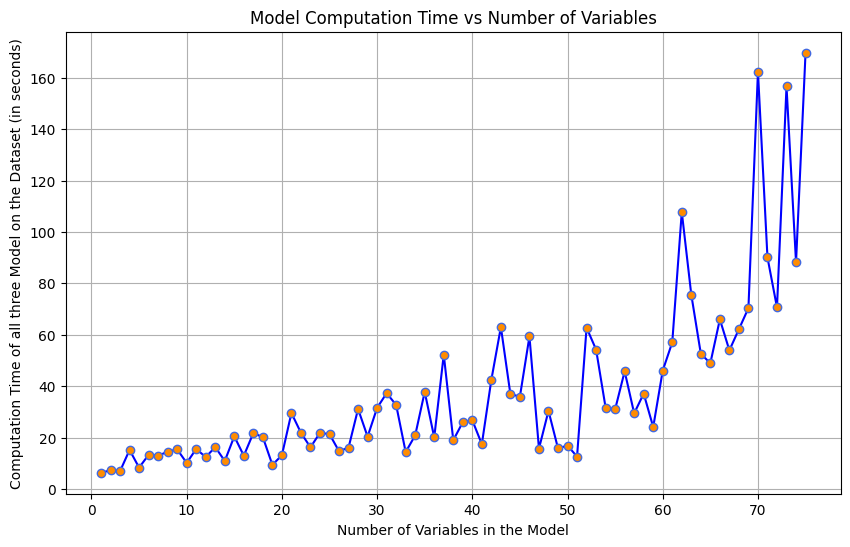

In [68]:
plt.figure(figsize=(10, 6))
plt.plot(df_time['Variables'], df_time['TimeInSeconds'], marker='o', linestyle='-', color='b',markerfacecolor='darkorange', markeredgecolor='royalblue')

# Set the title and labels
plt.title('Model Computation Time vs Number of Variables')
plt.xlabel('Number of Variables in the Model')
plt.ylabel('Computation Time of all three Model on the Dataset (in seconds)')

df_time['Variables'][67]
# Display the plot
plt.grid(True)
plt.savefig(f"021_simulation_figures/ComputationTime_Example.png")

plt.show()

#### Time Comparison of different Settings

In [49]:
import itertools
import time
import itertools
import os
import multiprocessing as mp # Mutli-Threading
from sklearn.model_selection import KFold
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import math
import log_hyperu as hyperu
import pandas as pd
from datetime import datetime
from sklearn.model_selection import train_test_split

def tgr_loss(output, target, model, tgr_reg_strength, a, c, kappa):
    mse_loss = nn.MSELoss()(output, target)
    phi = torch.tensor((2*c)/((kappa**2)*a))
    tgr_loss = tgr_reg_strength * torch.sum(-hyperu.log_hyperu(torch.tensor([[c+0.5]]),torch.tensor([[1.5-a]]),(model.linear.weight**2)/(2*phi))+hyperu.log_hyperu(torch.tensor([[c+0.5]]),torch.tensor([[1.5-a]]),torch.tensor([[0.0]])))

    return mse_loss + tgr_loss

class LinearRegression(nn.Module):
    def __init__(self, n_features):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(n_features, 1, bias=False)
        
    def forward(self, x):
        return self.linear(x)

def train_model(model, X_train, y_train, lr=0.01, n_epochs=500):
    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    
    for epoch in range(n_epochs):
        model.train()
        
        optimizer.zero_grad()
        outputs = model(X_train).squeeze()
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        
    return model
        

# Set random seed for reproducibility
torch.manual_seed(123) # 42
np.random.seed(123) # 42

# Step 1: Generate synthetic data using scenario
n_epochs = 500
runs = 25

n_samples = [100]
n_features = [10]
n_nonzero = [0.1]

scenario_combinations = list(itertools.product(n_samples, n_features, n_nonzero))
time_list = list()
# Make new simulation folder
current_datetime = datetime.now().strftime("%Y%m%d_%H%M%S")
simulation_folder_path = f'Time_Measurement_{current_datetime}'
os.makedirs(simulation_folder_path, exist_ok=True)

counter=0
for scen in scenario_combinations:
    output_list = list() # Contains Tuples with (METHOD, LAMBDA, LOSS, COEFS)
    counter = counter + 1
    for run in range(runs):
        n_samples = scen[0]
        n_features = scen[1]
        n_nonzero = math.ceil(scen[2]*scen[1])
        # True coefficients with sparsity (many coefficients are zero)
        true_coefficients = torch.zeros(n_features)
        true_coefficients[:n_nonzero] = torch.randn(n_nonzero)

        # Generate features
        X = torch.randn(n_samples, n_features)

        # Generate targets with noise
        noise = torch.randn(n_samples) * 0.5
        y = X @ true_coefficients + noise

        # Step 2: Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        tgr_reg_strength = 0.5
        # Train TGR Model - Setting 1
        start_time = time.time()
        tgr_model1 = LinearRegression(n_features)
        optimizer = torch.optim.SGD(tgr_model1.parameters(), lr=0.01)

        for epoch in range(n_epochs):
            tgr_model1.train()
            
            optimizer.zero_grad()
            outputs = tgr_model1(X_train).squeeze()
            loss = tgr_loss(outputs, y_train, tgr_model1, tgr_reg_strength, 0.75, 0.1, 2)
            loss.backward()
            nn.utils.clip_grad_norm_(tgr_model1.parameters(), 1.0)
            optimizer.step()
        end_time = time.time()
        time_list.append(("TGR1", run+1, end_time-start_time))
        # Train TGR Model - Setting 2
        start_time = time.time()
        tgr_model2 = LinearRegression(n_features)
        optimizer = torch.optim.SGD(tgr_model2.parameters(), lr=0.01)
        for epoch in range(n_epochs):
            tgr_model2.train()
            
            optimizer.zero_grad()
            outputs = tgr_model2(X_train).squeeze()
            loss = tgr_loss(outputs, y_train, tgr_model2, tgr_reg_strength, 5, 0.01, 2)
            loss.backward()
            nn.utils.clip_grad_norm_(tgr_model2.parameters(), 1.0)
            optimizer.step()
        end_time = time.time()
        time_list.append(("TGR2", run+1, end_time-start_time))
        # Train TGR Model - Setting 3
        start_time = time.time()
        tgr_model3 = LinearRegression(n_features)
        optimizer = torch.optim.SGD(tgr_model3.parameters(), lr=0.01)
        for epoch in range(n_epochs):
            tgr_model3.train()
            
            optimizer.zero_grad()
            outputs = tgr_model3(X_train).squeeze()
            loss = tgr_loss(outputs, y_train, tgr_model3, tgr_reg_strength, 0.51, 0.01, 1)
            loss.backward()
            nn.utils.clip_grad_norm_(tgr_model3.parameters(), 1.0)
            optimizer.step()
        end_time = time.time()
        time_list.append(("TGR3", run+1, end_time-start_time))
        # END RUNS LOOP
        print(f"Run {run+1} done!")

df_time = pd.DataFrame(time_list, columns=['Method', 'Run', 'TimeInSeconds'])


NameError: name 'hyperu' is not defined